<a href="https://colab.research.google.com/github/Mu-niu13/AIPI-590-HWs/blob/main/Mechanistic%20Interpretability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Mechanistic Interpretability

### Mu Niu

The below code chunks were generated using Claude 4.5 Sonnet on 11/9/2025 at 9:33pm.

https://claude.ai/public/artifacts/e7f1d376-c188-4e4d-a2c8-ac976717b2f0


#### Task

Modulo-3 detection (detecting if numbers 0-255 are divisible by 3)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA

## Part 1: Setup

### Data Generation

In [2]:
torch.manual_seed(42)
np.random.seed(42)

def number_to_binary(n, bits=8):
    """Convert number to binary representation"""
    binary = []
    for i in range(bits):
        binary.append((n >> i) & 1)
    return binary

def generate_modulo3_data(n_samples=2000, max_num=255):
    """
    Generate data for modulo-3 detection task.
    Input: 8-bit binary representation of numbers
    Output: 1 if divisible by 3, 0 otherwise
    """
    X = []
    y = []

    for _ in range(n_samples):
        num = np.random.randint(0, max_num + 1)
        binary = number_to_binary(num, bits=8)
        label = 1 if num % 3 == 0 else 0
        X.append(binary)
        y.append(label)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

# Generate training and validation data
X_train, y_train = generate_modulo3_data(2000)
X_val, y_val = generate_modulo3_data(500)

### Define Model

In [3]:
class ModuloDetector(nn.Module):
    """
    A small MLP for modulo-3 detection with interpretable hidden layer
    """
    def __init__(self, input_dim=8, hidden_dim=6):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)  # 2 classes: divisible or not

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        out = self.fc2(h)
        return out, h  # Return both output and hidden activations

model = ModuloDetector(input_dim=8, hidden_dim=6)
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")

ModuloDetector(
  (fc1): Linear(in_features=8, out_features=6, bias=True)
  (fc2): Linear(in_features=6, out_features=2, bias=True)
)

Total parameters: 68


## Model Training

In [4]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

train_losses = []
val_accs = []

for epoch in range(150):
    model.train()
    out, _ = model(X_train)
    loss = criterion(out, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    # Validation
    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_out, _ = model(X_val)
            val_pred = torch.argmax(val_out, dim=1)
            val_acc = (val_pred == y_val).float().mean().item()
            val_accs.append(val_acc)
            print(f"Epoch {epoch+1:3d} | Loss: {loss.item():.4f} | Val Acc: {val_acc:.4f}")

Epoch  10 | Loss: 0.6278 | Val Acc: 0.6620
Epoch  20 | Loss: 0.6177 | Val Acc: 0.6620
Epoch  30 | Loss: 0.6043 | Val Acc: 0.6620
Epoch  40 | Loss: 0.5853 | Val Acc: 0.6700
Epoch  50 | Loss: 0.5595 | Val Acc: 0.6880
Epoch  60 | Loss: 0.5306 | Val Acc: 0.7760
Epoch  70 | Loss: 0.5094 | Val Acc: 0.8480
Epoch  80 | Loss: 0.4965 | Val Acc: 0.9140
Epoch  90 | Loss: 0.4856 | Val Acc: 0.9300
Epoch 100 | Loss: 0.4760 | Val Acc: 0.9440
Epoch 110 | Loss: 0.4688 | Val Acc: 0.9440
Epoch 120 | Loss: 0.4617 | Val Acc: 0.9440
Epoch 130 | Loss: 0.4537 | Val Acc: 0.9440
Epoch 140 | Loss: 0.4453 | Val Acc: 0.9440
Epoch 150 | Loss: 0.4381 | Val Acc: 0.9440


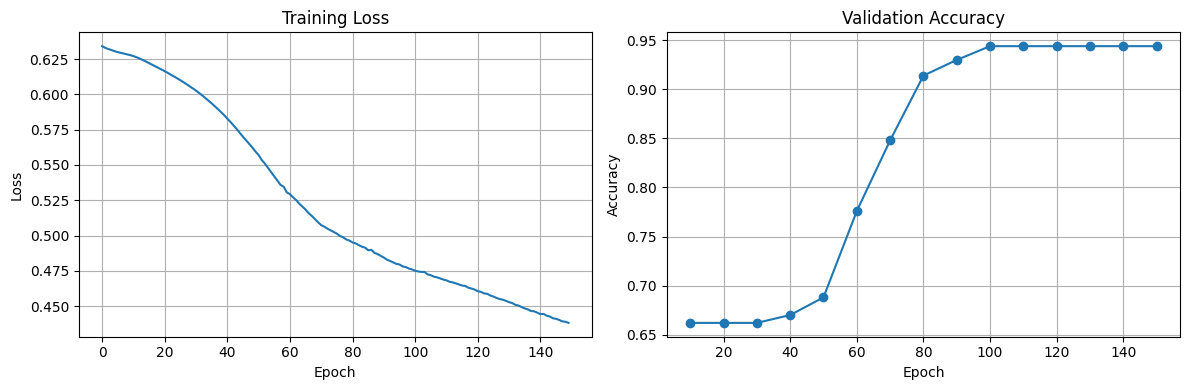

In [5]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(10, 151, 10), val_accs, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 2: Explore

## Weight Analysis

First layer weights shape: (6, 8)
Each of 6 hidden neurons connects to 8 input bits


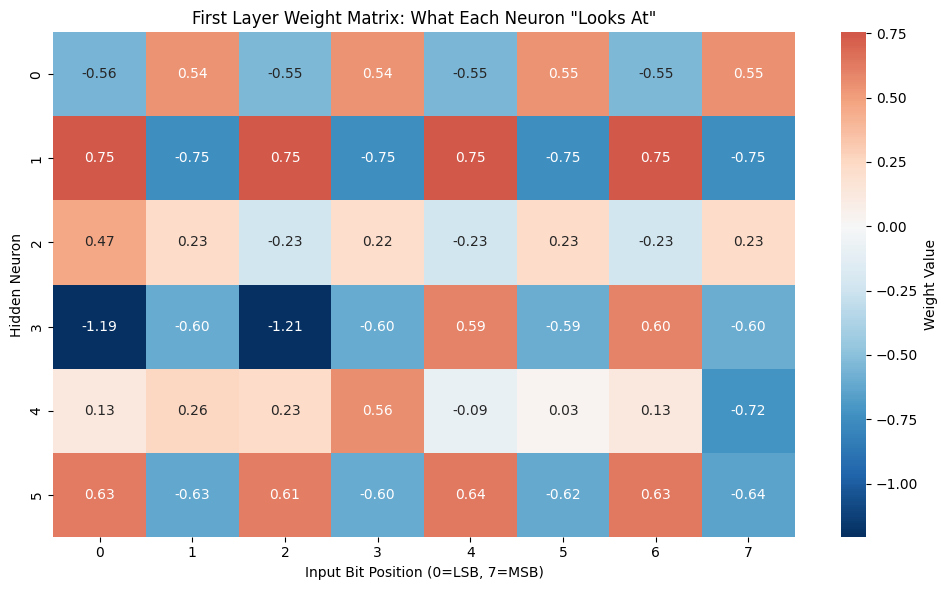

In [6]:
# Extract weights
fc1_weights = model.fc1.weight.data.numpy()
fc1_bias = model.fc1.bias.data.numpy()

print(f"First layer weights shape: {fc1_weights.shape}")
print(f"Each of 6 hidden neurons connects to 8 input bits")

# Visualize weight matrix
plt.figure(figsize=(10, 6))
sns.heatmap(fc1_weights, annot=True, fmt='.2f', cmap='RdBu_r',
            center=0, cbar_kws={'label': 'Weight Value'})
plt.xlabel('Input Bit Position (0=LSB, 7=MSB)')
plt.ylabel('Hidden Neuron')
plt.title('First Layer Weight Matrix: What Each Neuron "Looks At"')
plt.tight_layout()
plt.show()

## Activation Analysis

Samples NOT divisible by 3: 331
Samples divisible by 3: 169


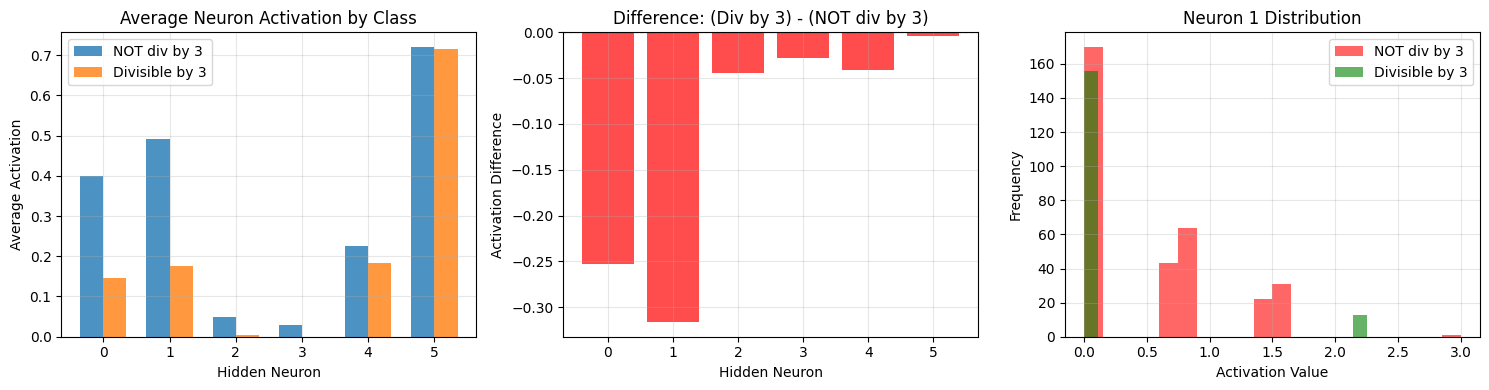

In [7]:
model.eval()
with torch.no_grad():
    _, hidden_val = model(X_val)

# Separate activations by class
hidden_class0 = hidden_val[y_val == 0].numpy()  # NOT divisible by 3
hidden_class1 = hidden_val[y_val == 1].numpy()  # Divisible by 3

print(f"Samples NOT divisible by 3: {len(hidden_class0)}")
print(f"Samples divisible by 3: {len(hidden_class1)}")

# Average activation per neuron per class
avg_act_class0 = hidden_class0.mean(axis=0)
avg_act_class1 = hidden_class1.mean(axis=0)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Average activations
x = np.arange(6)
width = 0.35
axes[0].bar(x - width/2, avg_act_class0, width, label='NOT div by 3', alpha=0.8)
axes[0].bar(x + width/2, avg_act_class1, width, label='Divisible by 3', alpha=0.8)
axes[0].set_xlabel('Hidden Neuron')
axes[0].set_ylabel('Average Activation')
axes[0].set_title('Average Neuron Activation by Class')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Activation difference
diff = avg_act_class1 - avg_act_class0
colors = ['green' if d > 0 else 'red' for d in diff]
axes[1].bar(x, diff, color=colors, alpha=0.7)
axes[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axes[1].set_xlabel('Hidden Neuron')
axes[1].set_ylabel('Activation Difference')
axes[1].set_title('Difference: (Div by 3) - (NOT div by 3)')
axes[1].grid(True, alpha=0.3)

# Plot 3: Distribution for most discriminative neuron
most_discriminative = np.argmax(np.abs(diff))
axes[2].hist(hidden_class0[:, most_discriminative], bins=20, alpha=0.6,
             label='NOT div by 3', color='red')
axes[2].hist(hidden_class1[:, most_discriminative], bins=20, alpha=0.6,
             label='Divisible by 3', color='green')
axes[2].set_xlabel('Activation Value')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Neuron {most_discriminative} Distribution')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Individual Neuron Analysis

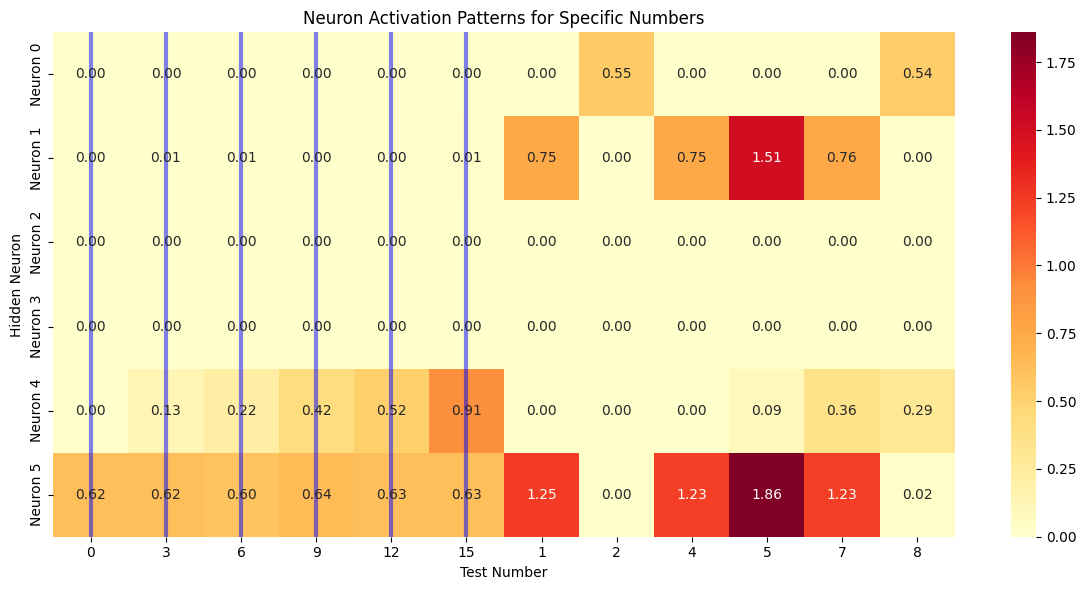

In [8]:
# Test on specific numbers
test_numbers = [0, 3, 6, 9, 12, 15, 1, 2, 4, 5, 7, 8]
test_inputs = []
test_labels = []

for num in test_numbers:
    test_inputs.append(number_to_binary(num, 8))
    test_labels.append(num % 3 == 0)

test_inputs = torch.tensor(test_inputs, dtype=torch.float32)

with torch.no_grad():
    _, test_hidden = model(test_inputs)

# Visualize neuron responses
plt.figure(figsize=(12, 6))
sns.heatmap(test_hidden.numpy().T, annot=True, fmt='.2f',
            cmap='YlOrRd', xticklabels=test_numbers,
            yticklabels=[f'Neuron {i}' for i in range(6)])
plt.xlabel('Test Number')
plt.ylabel('Hidden Neuron')
plt.title('Neuron Activation Patterns for Specific Numbers')

# Add markers for numbers divisible by 3
for idx, num in enumerate(test_numbers):
    if num % 3 == 0:
        plt.axvline(idx + 0.5, color='blue', linewidth=3, alpha=0.5)

plt.tight_layout()
plt.show()

## Feature Space Analysis

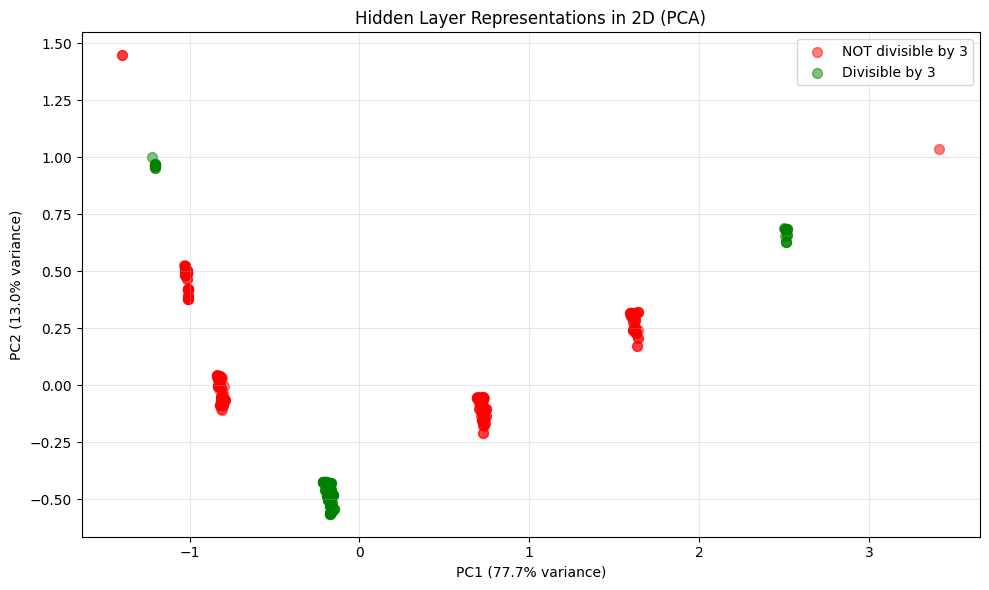

In [10]:
# Apply PCA to visualize hidden space
pca = PCA(n_components=2)
hidden_2d = pca.fit_transform(hidden_val.numpy())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(hidden_2d[y_val == 0, 0], hidden_2d[y_val == 0, 1],
                     c='red', alpha=0.5, label='NOT divisible by 3', s=50)
scatter = plt.scatter(hidden_2d[y_val == 1, 0], hidden_2d[y_val == 1, 1],
                     c='green', alpha=0.5, label='Divisible by 3', s=50)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Hidden Layer Representations in 2D (PCA)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Ablation Study

Baseline accuracy: 0.9600
Neuron 0: Accuracy = 0.9600 | Drop = +0.0000 
Neuron 1: Accuracy = 0.6300 | Drop = +0.3300 ⚠️ CRITICAL
Neuron 2: Accuracy = 0.9600 | Drop = +0.0000 
Neuron 3: Accuracy = 0.9600 | Drop = +0.0000 
Neuron 4: Accuracy = 0.9600 | Drop = +0.0000 
Neuron 5: Accuracy = 0.7300 | Drop = +0.2300 ⚠️ CRITICAL


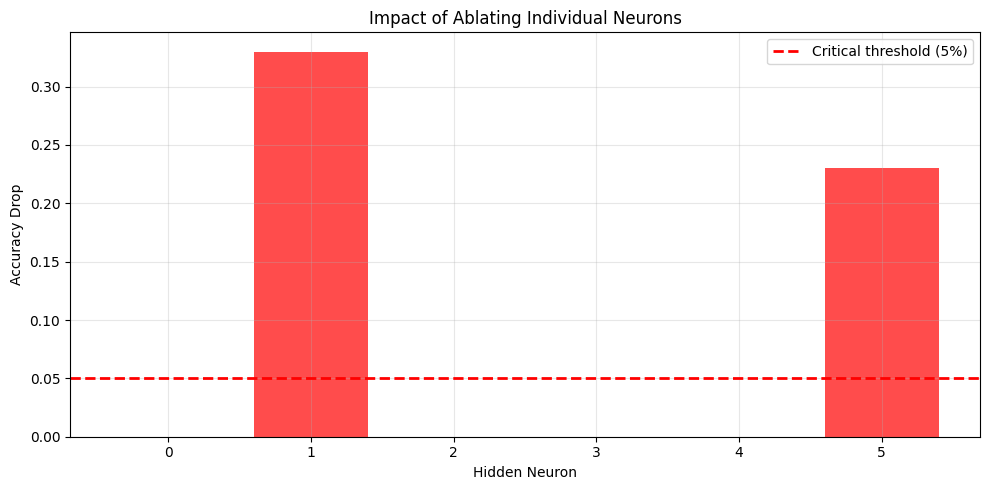

In [11]:
# Test ablation effect
test_sample = X_val[:100]
test_labels_sample = y_val[:100]

# Baseline performance
with torch.no_grad():
    baseline_out, baseline_hidden = model(test_sample)
    baseline_pred = torch.argmax(baseline_out, dim=1)
    baseline_acc = (baseline_pred == test_labels_sample).float().mean().item()

print(f"Baseline accuracy: {baseline_acc:.4f}")

# Ablate each neuron
ablation_results = []

for neuron_idx in range(6):
    with torch.no_grad():
        # Forward pass
        h = torch.relu(model.fc1(test_sample))

        # Zero out specific neuron
        h_ablated = h.clone()
        h_ablated[:, neuron_idx] = 0

        # Continue forward
        out_ablated = model.fc2(h_ablated)
        pred_ablated = torch.argmax(out_ablated, dim=1)
        acc_ablated = (pred_ablated == test_labels_sample).float().mean().item()

        drop = baseline_acc - acc_ablated
        ablation_results.append(drop)

        print(f"Neuron {neuron_idx}: Accuracy = {acc_ablated:.4f} | "
              f"Drop = {drop:+.4f} {'⚠️ CRITICAL' if drop > 0.05 else ''}")

# Visualize ablation impact
plt.figure(figsize=(10, 5))
colors = ['red' if x > 0.05 else 'orange' if x > 0.02 else 'green'
          for x in ablation_results]
bars = plt.bar(range(6), ablation_results, color=colors, alpha=0.7)
plt.axhline(0.05, color='red', linestyle='--', label='Critical threshold (5%)', linewidth=2)
plt.xlabel('Hidden Neuron')
plt.ylabel('Accuracy Drop')
plt.title('Impact of Ablating Individual Neurons')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Part 3: Explain


The weight matrix visualization (Image 1) shows that two hidden neurons (Neuron 1 and Neuron 5) learned a distinct alternating pattern across input bit weights. Neuron 1’s weights alternate almost perfectly in sign and magnitude, forming an alternating weighted sum of the input bits, which is mathematically aligned with modulo-3 detection. Neuron 5 displays a similar but slightly weaker version of this pattern, suggesting a secondary, redundant detector. In contrast, the remaining four neurons exhibit weaker or unstructured weight patterns, indicating limited functional contribution.

The activation plots (Image 2) confirm this specialization. Neuron 1 responds strongly to numbers not divisible by 3 while remaining near zero for multiples of 3, effectively acting as a discriminator. Neuron 5 shows a similar but less pronounced activation profile. The heatmap of individual activations across numbers (Image 3) further shows that Neuron 1 consistently fires on non-multiples and remains suppressed on multiples, which the ReLU makes distinctly separable. The PCA projection of the hidden representations (Image 4) shows clear clustering between divisible and non-divisible inputs, indicating that the network compresses the modulo-3 rule into a low-dimensional separable structure.

Finally, the ablation study (Image 5) demonstrates the causal importance of these neurons: removing Neuron 1 reduces accuracy by about 33% and removing Neuron 5 by about 23%, while removing any of the other four neurons causes little or no performance change. This shows that the network relies primarily on two functional hidden units, with the remaining neurons serving marginal or redundant roles.

## Part 4: Reflect

This experiment showed me that even a small neural network can solve interesting mathematical questions on its own. The alternating weight pattern wasn’t something I designed. It emerged naturally through training. And although the model had six neurons to work with, only two ended up doing most of the work, which suggests networks often settle on sparse, efficient solutions. Still, some parts remain puzzling, like why the network chose to detect “not divisible by 3” instead of the opposite, or how the clean alternating pattern formed during training. These open questions point to deeper work needed to understand how and why certain representations emerge.